In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import pickle

In [2]:
df = pd.read_excel('Data_Train.xlsx')
df.dropna(inplace=True)
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
df['Destination'].value_counts()

Destination
Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: count, dtype: int64

In [4]:
def newd(x):
    if x=='New Delhi':
        return 'Delhi'
    else:
        return x
    
df['Destination'] = df['Destination'].apply(newd)
df['Source'] = df['Source'].apply(newd)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


In [6]:
df['Journey_day'] = pd.to_datetime(df['Date_of_Journey'],format='%d/%m/%Y').dt.day
df['Journey_month'] = pd.to_datetime(df['Date_of_Journey'],format='%d/%m/%Y').dt.month

df.drop('Date_of_Journey',inplace=True,axis=1)

df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,Banglore,Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [7]:
df['Dep_hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
df['Dep_min'] = pd.to_datetime(df['Dep_Time']).dt.minute
df.drop('Dep_Time',axis=1,inplace=True)

df['Arrival_hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
df['Arrival_min'] = pd.to_datetime(df['Arrival_Time']).dt.minute
df.drop('Arrival_Time',axis=1,inplace=True)
df.head()

C:\Users\vishn\AppData\Local\Temp\ipykernel_15788\1302972749.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dep_hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
C:\Users\vishn\AppData\Local\Temp\ipykernel_15788\1302972749.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dep_min'] = pd.to_datetime(df['Dep_Time']).dt.minute
C:\Users\vishn\AppData\Local\Temp\ipykernel_15788\1302972749.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Arrival_hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
C:\Users\vishn\AppData\Local\Temp\ipykernel_15788\1302972749.py:

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [8]:
duration = list(df['Duration'])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if 'h' in duration[i]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i] = '0h ' + duration[i]

duration_hour = []
duration_min = []

for i in duration:
    h,m = i.split()
    duration_hour.append(int(h[:-1]))
    duration_min.append(int(m[:-1]))

    
df['Duration_hours'] = duration_hour
df['Duration_mins'] = duration_min
df.drop('Duration',axis=1,inplace=True)
df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


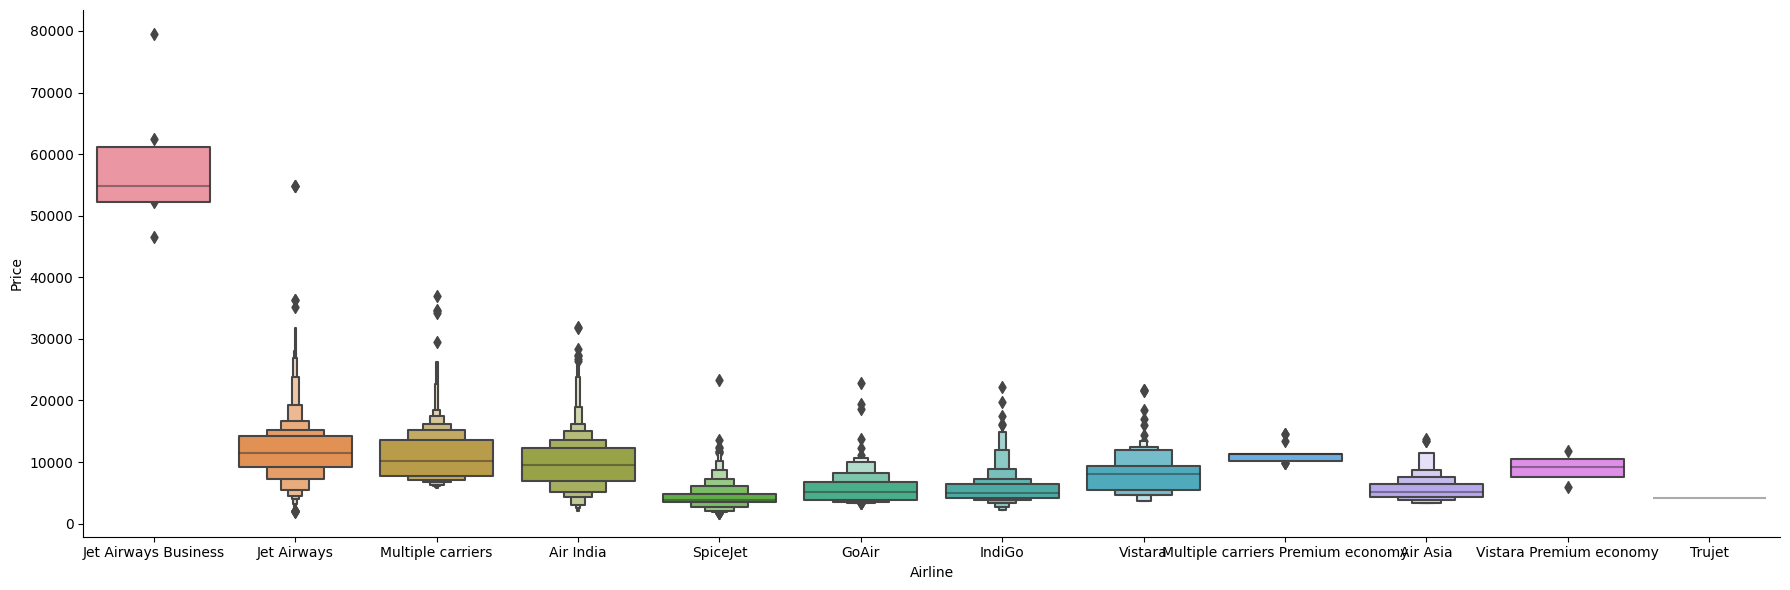

In [9]:
sns.catplot(x='Airline',y='Price',data=df.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=6)

In [10]:
airline = df[['Airline']]
airline = pd.get_dummies(airline,drop_first=True)

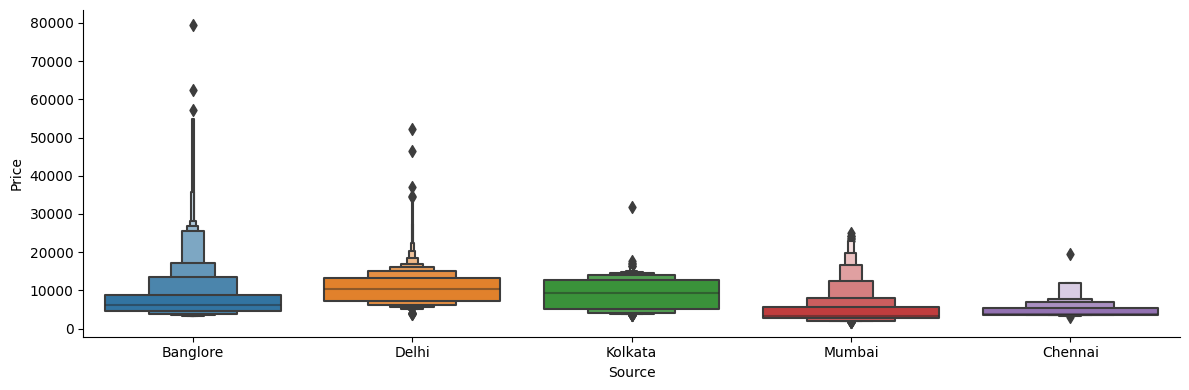

In [11]:
sns.catplot(x='Source',y='Price',data=df.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

In [12]:
source = df[['Source']]
source = pd.get_dummies(source,drop_first=True)
source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,False,False,False,False
1,False,False,True,False
2,False,True,False,False
3,False,False,True,False
4,False,False,False,False


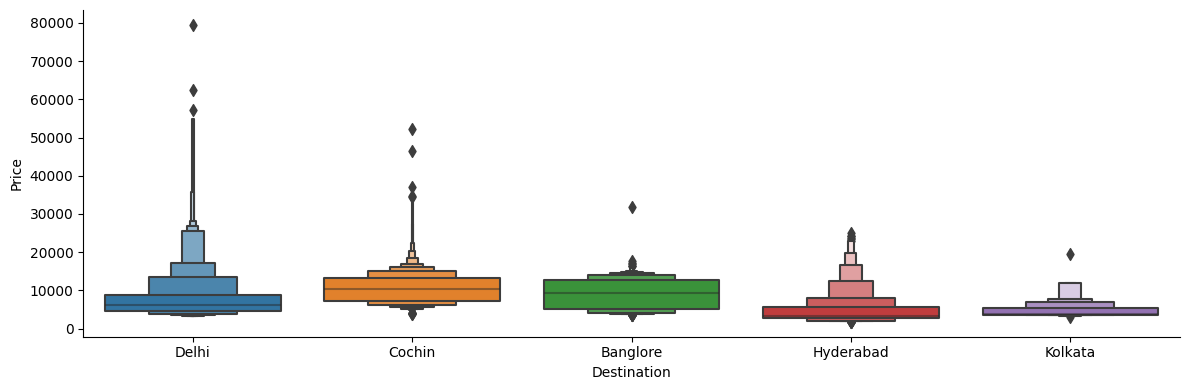

In [13]:
sns.catplot(x='Destination',y='Price',data=df.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

In [14]:
destination = df[['Destination']]
destination = pd.get_dummies(destination,drop_first=True)
destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,False,True,False,False
1,False,False,False,False
2,True,False,False,False
3,False,False,False,False
4,False,True,False,False


In [15]:
df.drop(['Route','Additional_Info'],inplace=True,axis=1)

In [16]:
df['Total_Stops'].value_counts()

Total_Stops
1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: count, dtype: int64

In [17]:
df['Total_Stops'].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4},inplace=True)
df.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1,13302,1,3,16,50,21,35,4,45


In [18]:
print(airline.shape)
print(source.shape)
print(destination.shape)
print(df.shape)

(10682, 11)
(10682, 4)
(10682, 4)
(10682, 13)


In [19]:
fd = pd.concat([df,airline,source,destination],axis=1)
fd.drop(['Airline','Source','Destination'],axis=1,inplace=True)
fd.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,3897,24,3,22,20,1,10,2,50,...,False,False,False,False,False,False,False,True,False,False
1,2,7662,1,5,5,50,13,15,7,25,...,False,False,False,False,True,False,False,False,False,False
2,2,13882,9,6,9,25,4,25,19,0,...,False,False,False,True,False,False,True,False,False,False
3,1,6218,12,5,18,5,23,30,5,25,...,False,False,False,False,True,False,False,False,False,False
4,1,13302,1,3,16,50,21,35,4,45,...,False,False,False,False,False,False,False,True,False,False


In [20]:
fd.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata'],
      dtype='object')

In [21]:
X = fd.drop('Price',axis=1)
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,24,3,22,20,1,10,2,50,False,...,False,False,False,False,False,False,False,True,False,False
1,2,1,5,5,50,13,15,7,25,True,...,False,False,False,False,True,False,False,False,False,False
2,2,9,6,9,25,4,25,19,0,False,...,False,False,False,True,False,False,True,False,False,False
3,1,12,5,18,5,23,30,5,25,False,...,False,False,False,False,True,False,False,False,False,False
4,1,1,3,16,50,21,35,4,45,False,...,False,False,False,False,False,False,False,True,False,False


In [22]:
y = fd['Price']
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

In [23]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),cmap='viridis',annot=True)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\vishn\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\vishn\AppData\Local\Temp\ipykernel_15788\4159584497.py", line 2, in <module>
    sns.heatmap(df.corr(),cmap='viridis',annot=True)
  File "c:\Users\vishn\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py", line 10054, in corr
    mat = data.to_numpy(dtype=float, na_value=np.nan, copy=False)
  File "c:\Users\vishn\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py", line 1837, in to_numpy
    result = self._mgr.as_array(dtype=dtype, copy=copy, na_value=na_value)
  File "c:\Users\vishn\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\managers.py", line 1732, in as_array
    arr = self._interleave(dtype=dtype, na_value=na_value)
  File "c:\Users\vishn\AppData\Local\Programs\Pyt

<Figure size 1000x1000 with 0 Axes>

In [24]:
reg = ExtraTreesRegressor()
reg.fit(X,y)

print(reg.feature_importances_)

[2.52834383e-01 1.42432102e-01 5.79190074e-02 2.38636615e-02
 2.11816723e-02 2.78839228e-02 1.92341150e-02 1.11263719e-01
 1.85857497e-02 1.03915727e-02 1.93424637e-03 1.85761608e-02
 1.32622491e-01 6.78174166e-02 2.03370043e-02 8.25710082e-04
 6.09166309e-03 1.19617258e-04 4.52864709e-03 6.25662707e-05
 6.27440176e-04 7.98790004e-03 4.60984063e-03 6.31405282e-03
 1.55945928e-02 1.85282364e-02 7.08858274e-03 7.43925190e-04]


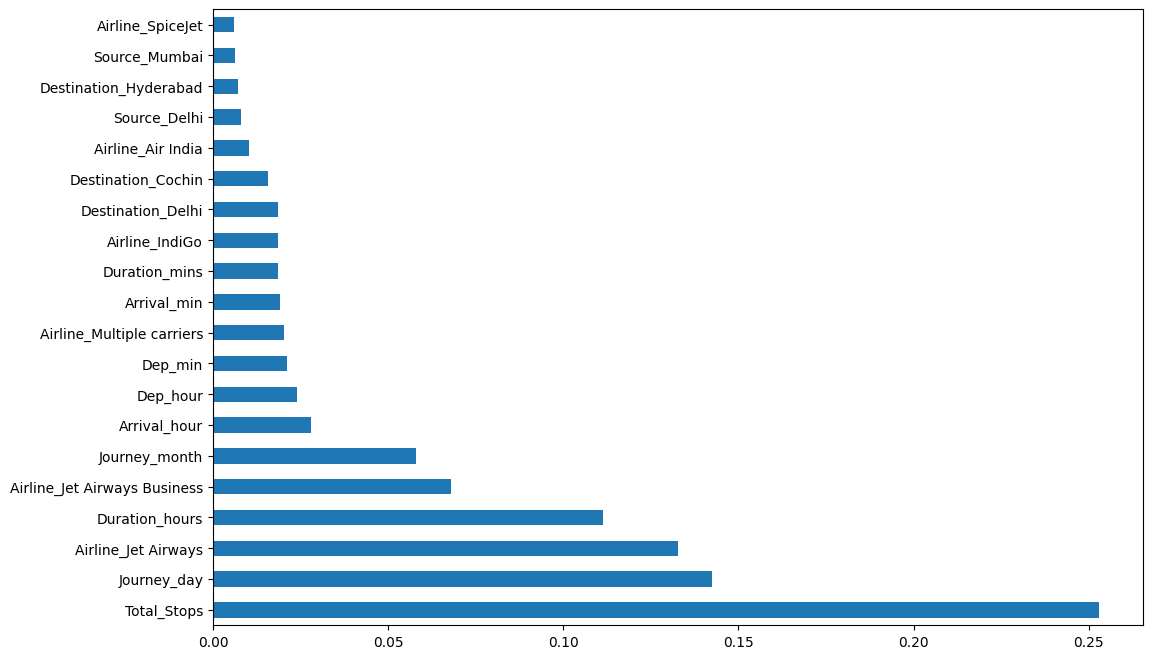

In [25]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5, 
                               verbose=1, random_state=42, n_jobs = 1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\vishn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\vishn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\vishn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_f

In [ ]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [ ]:
prediction = rf_random.predict(X_test)

C:\Users\vishn\AppData\Local\Temp\ipykernel_6136\375150797.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-prediction)


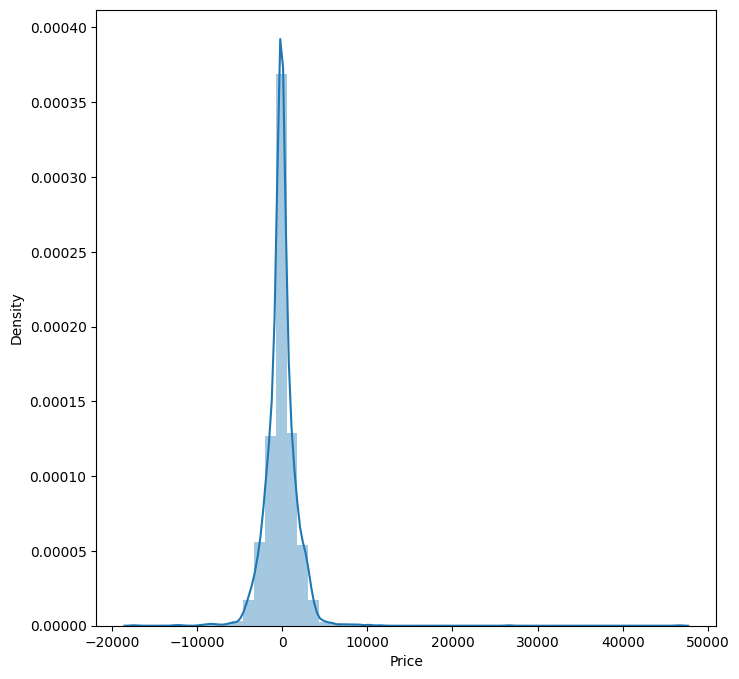

In [ ]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

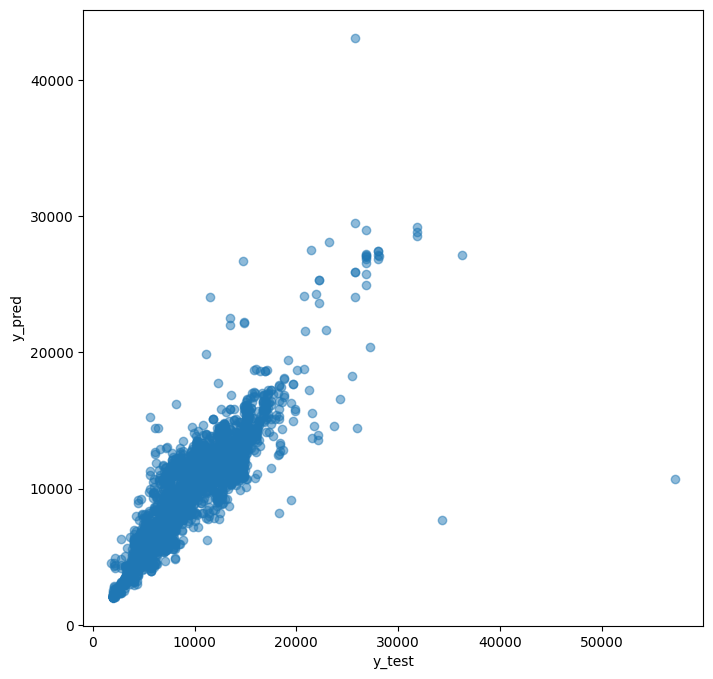

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [ ]:
print('r2 score: ', metrics.r2_score(y_test,y_pred))

r2 score:  0.8117139338462687


In [ ]:
file = open('flight_rf.pkl', 'wb')
pickle.dump(rf_random, file)